# Practice: Train a Neural Network on Make Moons

In this notebook, you'll apply everything you've learned to train a neural network on a **real dataset**!

**What you'll do:**
1. Generate the `make_moons` dataset (two interleaving crescents)
2. Visualize the data
3. Build an MLP classifier
4. Implement the training loop
5. Visualize the decision boundary

---

## How This Notebook Works

- **Instructions** explain what to do
- **TODO** sections are for you to fill in
- **Hints** are available if you get stuck
- **Solutions** are hidden - try first before looking!

---

## Step 1: Setup - Imports

First, let's import the libraries we need.

**New library**: `sklearn.datasets.make_moons` generates our training data!

In [2]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
# for sklean install use: pip install scikit-learn

%matplotlib inline

print("Imports successful!")

Imports successful!


## Step 2: Copy Your Value Class

Copy the `Value` class from your summary notebook (003-summary_brief_of_micrograd.ipynb).

This is the foundation - we need it for automatic differentiation!

In [3]:
# TODO: Copy your Value class here from the summary notebook
# It should include:
#   - __init__ with data, grad, _backward, _prev, _op
#   - __add__, __mul__, __pow__, __neg__, __sub__, __truediv__
#   - __radd__, __rsub__, __rmul__
#   - tanh(), exp()
#   - backward()

class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
		
	def __repr__(self):
		return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
	
	# Arithmetic operations

	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		
		def _backward():
			self.grad += out.grad
			other.grad += out.grad
		out._backward = _backward
		
		return out
	
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		
		return out
	
	def __pow__(self, exponent):
		assert isinstance(exponent, (int, float)), "Only supporting int/float powers for now"
		out = Value(self.data ** exponent, (self,), f'**{exponent}')
		
		def _backward():
			self.grad += exponent * (self.data ** (exponent - 1)) * out.grad
		out._backward = _backward
		
		return out
	
	def __neg__(self):
		return self * -1
	
	def __sub__(self, other):
		return self + (-other)
	
	def __truediv__(self, other):
		return self * other**-1
	
	# Reverse operations
	def __radd__(self, other):
		return self + other
	
	def __rsub__(self, other):
		return other + (-self)
	
	def __rmul__(self, other):
		return self * other
	

	# Activation functions
	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self,), 'tanh')
		
		def _backward():
			self.grad += (1 - t**2) * out.grad
		out._backward = _backward
		
		return out
	
	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self,), 'exp')
		
		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward
		
		return out
	
	# Backpropagation
	def backward(self):
		# Topological order all of the children in the graph
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)
		
		# Go one variable at a time and apply the chain rule to get its gradient
		self.grad = 1.0
		for node in reversed(topo):
			node._backward()
		



# Test it works:
# a = Value(2.0)
# b = Value(3.0)
# c = a + b
# print(f"2 + 3 = {c.data}")  # Should print 5.0

<details>
<summary><b>Click for Solution (Value class)</b></summary>

```python
class Value:
	def __init__(self, data, _children=(), _op='', label=''):
		self.data = data
		self.grad = 0.0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
	
	def __repr__(self):
		return f"Value(data={self.data:.4f}, grad={self.grad:.4f})"
	
	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')
		def _backward():
			self.grad += 1.0 * out.grad
			other.grad += 1.0 * out.grad
		out._backward = _backward
		return out
	
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')
		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		return out
	
	def __pow__(self, other):
		assert isinstance(other, (int, float))
		out = Value(self.data ** other, (self,), f'**{other}')
		def _backward():
			self.grad += other * (self.data ** (other - 1)) * out.grad
		out._backward = _backward
		return out
	
	def __neg__(self): return self * -1
	def __sub__(self, other): return self + (-other)
	def __truediv__(self, other): return self * (other ** -1)
	def __radd__(self, other): return self + other
	def __rsub__(self, other): return other + (-self)
	def __rmul__(self, other): return self * other
	
	def tanh(self):
		x = self.data
		t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
		out = Value(t, (self,), 'tanh')
		def _backward():
			self.grad += (1 - t ** 2) * out.grad
		out._backward = _backward
		return out
	
	def exp(self):
		out = Value(math.exp(self.data), (self,), 'exp')
		def _backward():
			self.grad += out.data * out.grad
		out._backward = _backward
		return out
	
	def backward(self):
		topo = []
		visited = set()
		def build_topo(node):
			if node not in visited:
				visited.add(node)
				for child in node._prev:
					build_topo(child)
				topo.append(node)
		build_topo(self)
		self.grad = 1.0
		for node in reversed(topo):
			node._backward()
```
</details>

## Step 3: Copy Your Neural Network Classes

Copy the `Neuron`, `Layer`, and `MLP` classes from your summary notebook.

In [4]:
# TODO: Copy your Neuron, Layer, and MLP classes here

class Neuron:
	def __init__(self, num_inputs):
		self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
		self.b = Value(random.uniform(-1, 1))
	
	def __call__(self, x):
		activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
		return activation.tanh()
	
	def parameters(self):
		return self.w + [self.b]

class Layer:
	def __init__(self, num_inputs, num_outputs):
		self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

	def __call__(self, x):
		outputs = [neuron(x) for neuron in self.neurons]

		return outputs[0] if len(outputs) == 1 else outputs
	
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
	def __init__(self, num_inputs, layer_sizes):
		sizes = [num_inputs] + layer_sizes
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layer_sizes))]

	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

<details>
<summary><b>Click for Solution (Neuron, Layer, MLP)</b></summary>

```python
class Neuron:
	def __init__(self, num_inputs):
		self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
		self.b = Value(random.uniform(-1, 1))
	
	def __call__(self, x):
		activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
		return activation.tanh()
	
	def parameters(self):
		return self.w + [self.b]

class Layer:
	def __init__(self, num_inputs, num_outputs):
		self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]
	
	def __call__(self, x):
		outputs = [neuron(x) for neuron in self.neurons]
		return outputs[0] if len(outputs) == 1 else outputs
	
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
	def __init__(self, num_inputs, layer_sizes):
		sizes = [num_inputs] + layer_sizes
		self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(layer_sizes))]
	
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]
```
</details>

## Step 4: Generate the Make Moons Dataset

Now let's create our training data!

**`make_moons`** creates two interleaving half-circles (crescents/moons).

Parameters:
- `n_samples`: How many points to generate
- `noise`: Adds randomness to make it more realistic
- `random_state`: For reproducibility

Returns:
- `X`: The 2D coordinates of each point (shape: n_samples x 2)
- `y`: The class label (0 or 1) for each point

In [5]:
# TODO: Generate the dataset
# Use make_moons with:
#   - n_samples=100 (100 data points)
#   - noise=0.1 (small amount of noise)
#   - random_state=42 (for reproducibility)

# X, y = make_moons(...)  # Fill in the parameters!
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

# Print the shapes to verify
print(f"X shape: {X.shape}")  # Should be (100, 2)
print(f"y shape: {y.shape}")  # Should be (100,)
print(f"First 5 points:\n{X[:5]}")
print(f"First 5 labels: {y[:5]}")

X shape: (100, 2)
y shape: (100,)
First 5 points:
[[ 1.58202308 -0.44581483]
 [ 0.0660451   0.4392075 ]
 [ 0.73663111 -0.39896339]
 [-1.05692838  0.2424558 ]
 [-0.80216162  0.20271838]]
First 5 labels: [1 1 1 0 0]


<details>
<summary><b>Click for Solution</b></summary>

```python
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

print(f"X shape: {X.shape}")  # (100, 2)
print(f"y shape: {y.shape}")  # (100,)
print(f"First 5 points:\n{X[:5]}")
print(f"First 5 labels: {y[:5]}")
```
</details>

## Step 5: Convert Labels to -1 and +1

The labels from `make_moons` are 0 and 1, but our network outputs values between -1 and +1 (because of tanh).

**Task**: Convert labels from {0, 1} to {-1, +1}

**Hint**: `y * 2 - 1` transforms 0 → -1 and 1 → +1

In [6]:
# TODO: Convert labels from {0, 1} to {-1, +1}
# y = ???

y = y * 2 - 1

# Verify:
print(f"Unique labels: {np.unique(y)}")  # Should be [-1, 1]

Unique labels: [-1  1]


<details>
<summary><b>Click for Solution</b></summary>

```python
y = y * 2 - 1  # 0 -> -1, 1 -> +1
print(f"Unique labels: {np.unique(y)}")  # [-1, 1]
```
</details>

## Step 6: Visualize the Data

Let's see what our data looks like! We'll plot the two classes in different colors.

**Task**: Create a scatter plot where:
- X-axis = first feature (X[:, 0])
- Y-axis = second feature (X[:, 1])
- Color = class label (y)

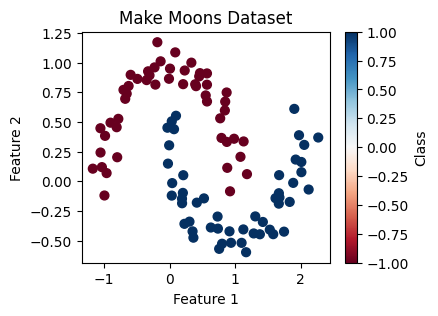

In [7]:
# TODO: Visualize the data
# Use plt.scatter with:
#   - X[:, 0] for x-coordinates
#   - X[:, 1] for y-coordinates  
#   - c=y for colors (different color per class)
#   - cmap='RdBu' for a nice red-blue colormap

# plt.figure(figsize=(8, 6))
# plt.scatter(???, ???, c=???, cmap='RdBu', s=40)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('Make Moons Dataset')
# plt.colorbar(label='Class')
# plt.show()

plt.figure(figsize=(4, 3)) # width=4, height=3
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', s=40) # x-coordinates, y-coordinates, colors, size
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Make Moons Dataset')
plt.colorbar(label='Class')
plt.show()

<details>
<summary><b>Click for Solution</b></summary>

```python
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', s=40)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Make Moons Dataset')
plt.colorbar(label='Class')
plt.show()
```
</details>

## Step 7: Create the Neural Network

Now let's build our classifier!

**Architecture**: We need a network that:
- Takes **2 inputs** (the x,y coordinates of each point)
- Outputs **1 value** (prediction: -1 or +1)
- Has hidden layers to learn the curved decision boundary

**Recommended architecture**: `MLP(2, [16, 16, 1])`
- 2 inputs
- 16 neurons in first hidden layer
- 16 neurons in second hidden layer  
- 1 output

In [8]:
# TODO: Create the MLP
# random.seed(42)  # For reproducibility
# model = MLP(2, [16, 16, 1])

# Lets create a MLP model
random.seed(17) # For always having same random numbers
model = MLP(2, [16, 16, 1])

print(f"Model created!")
print(f"Total parameters: {len(model.parameters())}")

Model created!
Total parameters: 337


## Step 8: Define the Loss Function

We need a way to measure how wrong our predictions are.

For binary classification, we'll use the **hinge loss** (SVM-style max-margin loss):

```
loss = max(0, 1 - y * prediction)
```

**How it works:**
- If `y = 1` and `prediction = 1` → `1 - 1*1 = 0` → loss = 0 (perfect!)
- If `y = 1` and `prediction = -1` → `1 - 1*(-1) = 2` → loss = 2 (bad!)
- If `y = -1` and `prediction = -1` → `1 - (-1)*(-1) = 0` → loss = 0 (perfect!)

The loss is 0 when the prediction has the right sign with margin ≥ 1.

We'll also add **L2 regularization** to prevent overfitting:
```
regularization = alpha * sum(p.data**2 for p in parameters)
```

In [9]:
def compute_loss(model, X, y, alpha=1e-4):
	"""
	Compute hinge loss with L2 regularization.
	
	Args:
		model: The MLP
		X: Input data (numpy array)
		y: Labels (-1 or +1)
		alpha: Regularization strength
	
	Returns:
		total_loss: Value object (so we can backprop!)
		accuracy: Float
	"""
	# TODO: Implement the loss function
	
	# Step 1: Forward pass - get predictions for all inputs
	# inputs = [list(row) for row in X]  # Convert numpy rows to lists
	# predictions = [model(x) for x in inputs]
	
	# Step 2: Compute hinge losses
	# For each (yi, pred) pair: loss_i = max(0, 1 - yi * pred)
	# In code, we can use ReLU: (1 - yi*pred) if (1-yi*pred).data > 0 else Value(0)
	# Or simpler: (1 + (-yi * pred)).relu() but we don't have relu...
	# So: losses = [(1 + -yi * predi) for yi, predi in zip(y, predictions)]
	#     losses = [loss if loss.data > 0 else Value(0) for loss in losses]
	
	# Step 3: Average the losses
	# data_loss = sum(losses) * (1.0 / len(losses))
	
	# Step 4: Add L2 regularization
	# reg_loss = alpha * sum(p*p for p in model.parameters())
	
	# Step 5: Total loss
	# total_loss = data_loss + reg_loss
	
	# Step 6: Compute accuracy (for monitoring)
	# accuracy = sum(1 for yi, predi in zip(y, predictions) 
	#               if (yi > 0) == (predi.data > 0)) / len(y)
	
	# return total_loss, accuracy
	

	# forward pass
	inputs = [list(row) for row in X] # X is the input from many_moons
	prediction = [model(x) for x in inputs]

	# calculate loss - Hinge loss for each point: max(0, 1 - y * prediction)
	losses = []
	for yi,pred in zip(y,prediction):
		margin = 1 + (-yi) * pred
		# ReLu (__/)
		if margin.data > 0:
			losses.append(margin)
		else:
			losses.append(Value(0))
	# average the losses to get one number not list
	avg_data_loss = sum(losses) * (1.0 / len(losses))
	# L2 regularization - prevents the network from relying too heavily on any single weight
	reg_loss = alpha * sum(p*p for p in model.parameters())

	total_loss = avg_data_loss + reg_loss

	# for us to monitor - how much % of prediction have right sign
	accuracy = sum(1 for yi, pred in zip(y, prediction) if (yi > 0) == (pred.data > 0)) / len(y)

	return total_loss, accuracy

# Test it:
# loss, acc = compute_loss(model, X, y)
# print(f"Loss: {loss.data:.4f}")
# print(f"Accuracy: {acc*100:.1f}%")

<details>
<summary><b>Click for Solution</b></summary>

```python
def compute_loss(model, X, y, alpha=1e-4):
	# Forward pass
	inputs = [list(row) for row in X]
	predictions = [model(x) for x in inputs]
	
	# Hinge loss: max(0, 1 - y*pred)
	losses = []
	for yi, predi in zip(y, predictions):
		margin = 1 + (-yi) * predi  # 1 - y*pred
		# ReLU (max with 0)
		if margin.data > 0:
			losses.append(margin)
		else:
			losses.append(Value(0))
	
	data_loss = sum(losses) * (1.0 / len(losses))
	
	# L2 regularization
	reg_loss = alpha * sum(p*p for p in model.parameters())
	
	total_loss = data_loss + reg_loss
	
	# Accuracy
	accuracy = sum(1 for yi, predi in zip(y, predictions) 
				  if (yi > 0) == (predi.data > 0)) / len(y)
	
	return total_loss, accuracy
```
</details>

## Step 9: The Training Loop!

This is where the magic happens! We'll:

1. **Forward pass**: Compute predictions and loss
2. **Zero gradients**: Reset all gradients to 0
3. **Backward pass**: Compute gradients
4. **Update weights**: Apply gradient descent

**Hyperparameters:**
- `learning_rate = 1.0` (can try 0.1 to 1.0)
- `num_iterations = 100` (can try more for better results)

In [10]:
# TODO: Implement the training loop

# learning_rate = 1.0
# num_iterations = 100

# print("Training...")
# print("-" * 50)

# for iteration in range(num_iterations):
#     
#     # Step 1: Forward pass - compute loss and accuracy
#     loss, accuracy = compute_loss(model, X, y)
#     
#     # Step 2: Zero all gradients
#     for p in model.parameters():
#         p.grad = 0.0
#     
#     # Step 3: Backward pass
#     loss.backward()
#     
#     # Step 4: Update weights (gradient descent)
#     for p in model.parameters():
#         p.data -= learning_rate * p.grad
#     
#     # Print progress every 10 iterations
#     if iteration % 10 == 0:
#         print(f"Iteration {iteration:3d} | Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")

# print("-" * 50)
# print(f"Final - Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")

learning_rate = 0.1
num_iteration = 150

print("Training...")
print("="*50)

for iteration in range(num_iteration):
    
	# Forward pass
    loss, accuracy = compute_loss(model, X, y)
    
	# Zero all gradient
    for p in model.parameters():
        p.grad = 0.0
        
	# backward pass
    loss.backward()
    
	# update the weigth (gardient descent)
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
	# print every 10 steps
    if iteration % 10 == 0:
        print(f"Iteration {iteration:3d} | Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")
        

print("="*50)
print(f"Final - Loss: {loss.data:.4f} | Accuracy: {accuracy*100:.1f}%")

Training...
Iteration   0 | Loss: 0.8656 | Accuracy: 50.0%
Iteration  10 | Loss: 0.3038 | Accuracy: 86.0%
Iteration  20 | Loss: 0.2779 | Accuracy: 88.0%
Iteration  30 | Loss: 0.2604 | Accuracy: 90.0%
Iteration  40 | Loss: 0.2467 | Accuracy: 91.0%
Iteration  50 | Loss: 0.2350 | Accuracy: 91.0%
Iteration  60 | Loss: 0.2245 | Accuracy: 91.0%
Iteration  70 | Loss: 0.2144 | Accuracy: 91.0%
Iteration  80 | Loss: 0.2038 | Accuracy: 91.0%
Iteration  90 | Loss: 0.1924 | Accuracy: 93.0%
Iteration 100 | Loss: 0.1803 | Accuracy: 93.0%
Iteration 110 | Loss: 0.1680 | Accuracy: 94.0%
Iteration 120 | Loss: 0.1562 | Accuracy: 96.0%
Iteration 130 | Loss: 0.1451 | Accuracy: 97.0%
Iteration 140 | Loss: 0.1348 | Accuracy: 97.0%
Final - Loss: 0.1262 | Accuracy: 98.0%


## Step 10: Visualize the Decision Boundary!

This is the coolest part - let's see what the network learned!

We'll:
1. Create a grid of points covering the plot area
2. Get the network's prediction for each point
3. Color the background based on predictions
4. Overlay the original data points

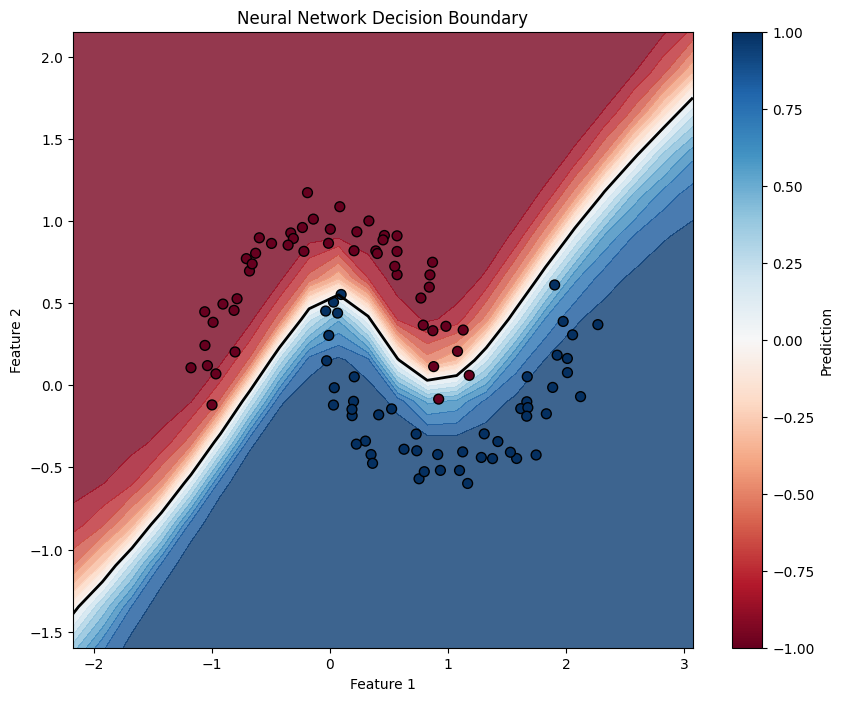

In [13]:
def plot_decision_boundary(model, X, y):
	"""
	Plot the decision boundary learned by the model.
	"""
	# Create a mesh grid
	h = 0.25  # Step size in the mesh
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
						 np.arange(y_min, y_max, h))
	
	# Get predictions for each point in the mesh
	mesh_points = np.c_[xx.ravel(), yy.ravel()]
	Z = []
	for point in mesh_points:
		pred = model(list(point))
		Z.append(pred.data)
	Z = np.array(Z).reshape(xx.shape)
	
	# Plot
	plt.figure(figsize=(10, 8))
	plt.contourf(xx, yy, Z, levels=np.linspace(-1, 1, 20), cmap='RdBu', alpha=0.8)
	plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)  # Decision boundary
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='black', s=50)
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('Neural Network Decision Boundary')
	plt.colorbar(label='Prediction')
	plt.show()

# TODO: Call the function after training!
plot_decision_boundary(model, X, y)

---

## Congratulations!

You've just trained a neural network to classify the make_moons dataset!

**What you accomplished:**
- Used a real dataset from scikit-learn
- Built an MLP classifier from scratch
- Implemented hinge loss with regularization
- Trained the network with gradient descent
- Visualized the learned decision boundary

---

## Bonus Challenges

If you want more practice, try:

1. **Change the noise**: Try `noise=0.2` or `noise=0.3` and see how training changes

2. **More data**: Try `n_samples=200` or `n_samples=500`

3. **Different architectures**: Try `MLP(2, [8, 8, 1])` or `MLP(2, [32, 32, 1])`

4. **Different learning rates**: Try `learning_rate = 0.1` or `learning_rate = 2.0`

5. **Use MSE loss instead**: Replace hinge loss with Mean Squared Error

In [12]:
# Bonus: Try your experiments here!
